In [2]:
import tensorflow as tf
import numpy as np
from tqdm import tnrange
import gzip
import matplotlib.pyplot as plt

# Introduction to Neural Networks

If you have found this tutorial, you have most likely heard of Neural Networks before, but what is a Neural network?  Structurally, a neural network is comprized of layers of neurons where each neuraon contains a single number.  These layers are connected by weights that allow the data to flow from neuron to neuron. The following diagram is what is known as a MultiLayered Perceptron (MLP) Network.  ![NN_diagram.png](figs/NN_diagram.png)  It consists of an Input Layer (blue) where each neuron stores the value of an input.  An Output layer (green) where each neuron contains a value of the output.  And at least one hidden layer between them.  These layers are arranged in a sequence, and each layer is densely connected to the layer before it.  This means the each neuron is connected to all of the neurons in the previous layer.  How the value in a neuron in any layer but the input layer is calculated is by multiplying all the values in the connected Neurons by the weight connecting them, and then summing all these products together with a bias.  After this is done, a non-linear activation function is applied to the value of the sum.  This can be written out mathematically as matrix multiplication if we view the values of each layer as a vecotr:
\begin{equation}
\mathbf{h}_{i+1} = \sigma\left(W_i\mathbf{h}_i + b_i\right)
\end{equation}
where $W_i$ is a matrix of the weights connecting layers $i$ and $i+1$, $b_i$ are the biases, $\mathbf{h}_i$ is the vector contain

## MNIST Integer Classification

The MNIST data set is a curated set of images of hand drawn numerals.  The following are samples from the dataset: ![MNIST_Images.png](figs/MNIST_Images.png) A classic problem is to build a machine learner that is capable of classifying the images as whatever number is represented, that is what we will be doing in this tutorial.  The first thing we need to is load the dataset. There are parts that need to be loaded, 2 sets of images, and 2 sets of labels.  The labels are the numbers that are drawn on the images, we will need these to train the learner.  The two sets are a training set and a validation set.  The training set is a set of 60,000 images that will be used to train the our learner.  The validation set is a set of 10,000 images that are not in the training set.  These images will be used to occasionally evaluate the learner to see how it performs on data it has not been trained on.  This helps determine if the learner is learning data representations, or if it is just memorizing the training set.  This concept will be discussed later in more detail, for now, the first step is to load the datasets.  The dataset is available [here](http://yann.lecun.com/exdb/mnist/) and is included in this repo.

In [3]:
print('Load Training Data...')
with gzip.open('../../data/MNIST/MNIST_train_imgs.idx3-ubyte.gz', 'rb') as file:
    mn = int.from_bytes(file.read(4), byteorder='big')
    if mn != 2051:
        print('Trainiing Data file corrupt, Magic Number is %d'%mn)
        exit(1)
        
    train_size = int.from_bytes(file.read(4), byteorder='big')
    train_n_rows = int.from_bytes(file.read(4), byteorder='big')
    train_n_cols = int.from_bytes(file.read(4), byteorder='big')
                
    train_dat = np.zeros((train_size, train_n_rows, train_n_cols))
                
    for i in tnrange(train_size):
        for j in range(train_n_rows):
            for k in range(train_n_cols):
                train_dat[i, j, k] = float(int.from_bytes(file.read(1), byteorder='big'))/255.0
    
print('Loading Training Labels...')
with gzip.open('../../data/MNIST/MNIST_train_labels.idx1-ubyte.gz', 'rb') as file:
    mn = int.from_bytes(file.read(4), byteorder='big')
    if mn != 2049:
        print('Training Labels file corrupt, Magic Number is %d'%mn)
        exit(1)
                    
    train_size_l = int.from_bytes(file.read(4), byteorder='big')
    train_labels = np.zeros((train_size_l, 10))
                
    for i in tnrange(train_size_l):
        train_labels[i, int.from_bytes(file.read(1), byteorder='big')] = 1.0
                            
print('Loading Validation Data...')   
with gzip.open('../../data/MNIST/MNIST_valid_imgs.idx3-ubyte.gz', 'rb') as file:
    mn = int.from_bytes(file.read(4), byteorder='big')
    if mn != 2051:
        print('Validation Data file corrupt, Magic Number is %d'%mn)
        exit(1)
                
    valid_size = int.from_bytes(file.read(4), byteorder='big')
    valid_n_rows = int.from_bytes(file.read(4), byteorder='big')
    valid_n_cols = int.from_bytes(file.read(4), byteorder='big')
                
    valid_dat = np.zeros((valid_size, valid_n_rows, valid_n_cols))
                
    for i in tnrange(valid_size):
        for j in range(valid_n_rows):
            for k in range(valid_n_cols):
                valid_dat[i, j, k] = float(int.from_bytes(file.read(1), byteorder='big'))/255.0
                            
print('Loading Validation Labels')
with gzip.open('../../data/MNIST/MNIST_valid_labels.idx1-ubyte.gz', 'rb') as file:
    mn = int.from_bytes(file.read(4), byteorder='big')
    if mn != 2049:
        print('Validation Labels file corrupt, Magic Number is %d'%mn)
        exit(1)
                    
    valid_size_l = int.from_bytes(file.read(4), byteorder='big')
    valid_labels = np.zeros((valid_size_l, 10))
                
    for i in tnrange(valid_size_l):
        valid_labels[i, int.from_bytes(file.read(1), byteorder='big')] = 1.0
                            
assert valid_size == valid_size_l
assert train_size == train_size_l
assert valid_n_rows == train_n_rows
assert valid_n_cols == train_n_cols
    
n_cols = train_n_cols
n_rows = train_n_rows

Load Training Data...



Loading Training Labels...



Loading Validation Data...



Loading Validation Labels


## Build The Network

Now we need to build the network in tensorflow.  For details on tensorflow, see the previous tutorials.  For this problem, we will be using a MultiLayer Perceptron (MLP) network.  This network consists of at least one hidden layer where each layer is densely connected with non-linear activation.  Before we apply the MLP, we will flatten the image from a 2D tensor to a 1D vector.  We will then use two hidden layers of ReLu units.  ReLu is a popular activation function defined as:
\begin{equation}
ReLu\left(x\right) = max\left\lbrace x, 0 \right\rbrace
\end{equation}
Finally, we will add the output layer which is also densly connected to the second hidden layer with softmax activation.  Softmax ephasises the maximum value in a vector, tending it towards 1, while minimizing all the other elements to 0.  It is often used as the output activation for classification networks as it will emphasise which case the classifier things the input is.
\begin{equation}
Softmax\left(\mathbf{z}\right) = \mathbf{x}
\end{equation}
where
\begin{equation}
x_i = \frac{exp\left(z_i\right)}{\sum^K_{j=1}exp\left(z_j\right)} \forall i \in \left[ 1, K\right]
\end{equation}
where $x_i$ and $z_i$ are the $i$th elements of $\mathbf{x}$ and $\mathbf{z}$ respectively.

Note that the output of this network is a 10 dimenstional vector, rather than a single number.  While we are trying to learn numerals, this is a classification problem trying to learn the *shape* of the numerals in the image and classify them as 0-9.  each element in the output vector represents each numeral, and the value represents a certainty of the network in its classification of the input as that numeral.  This is called "One Hot" representation and is a common representation of labels for classification problems.  Note that the labels were also loaded in a one hot format.

Once we have built the network, we specify the loss function.  For this task, we will use a Mean Squared Error (MSE) term, that is the mean of the square of the error between the predicted labels and the correct labels.  After this is defined, we setup the optimizer that will perform the training.  For this problem, we will use the [Adam](https://arxiv.org/abs/1412.6980) algorithm.  We set it up to minimize our specified loss function.

In [4]:
h1_size = 20 # first hidden layer size
h2_size = 15 # second hidden layer size

learning_rate = 0.0001

with tf.variable_scope('MNIST_Integer_Recognition') as scope:
    # Specify inputs
    img_in = tf.placeholder('float', [None, n_rows, n_cols], 'input_img')
    label_true = tf.placeholder('float', [None, 10], 'true_label')
        
    # Build network
    img_flat = tf.layers.flatten(img_in, 'flatten')
    h1 = tf.layers.dense(img_flat, h1_size, tf.nn.relu, name='h1')
    h2 = tf.layers.dense(h1, h2_size, tf.nn.relu, name='h2')
    label_pred = tf.layers.dense(h2, 10, tf.nn.softmax, name='label_pred')
        
    # Calculate loss
    loss = tf.reduce_mean(tf.squared_difference(label_pred, label_true))
        
    # Setup Optimizer
    trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = trainer.minimize(loss)

## Train the Network

Now that we have built the network, we can train the network.  We will train this network over a seriese of epochs.  One epoch involves training the network on all the values in the training set.  The training set is randomly shuffeled each epoch and organized into batches.  Each batch is passed to the training operation, which calculates the gradient of the average loss over the batch with respect to all the weights in the network.  The weights are then adjusted according to this gradient.  After the network has been trained on every element in the training set, the average loss of the validation set is calculated.  This value is saved along with the average loss of the training set.  After the training is completed, the prediction for the validation set is calculated.

In [5]:
n_epochs = 50
batch_size = 128

n_batches = int(np.ceil(train_size/batch_size))
losses = np.zeros((n_epochs, 2))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print('Training...')
    epoch_bar = tnrange(n_epochs)
    epoch_bar.set_description('Val. Loss: N/A')
    for epoch in epoch_bar:
        # shuffle data
        perm = np.random.permutation(train_size)
        
        batch_bar = tnrange(n_batches)
        batch_bar.set_description('Ave. Loss: N/A')
        for batch in batch_bar:
            # get batch
            batch_imgs = train_dat[perm[batch*batch_size:min((batch+1)*batch_size, train_size)], :, :]
            batch_labels = train_labels[perm[batch*batch_size:min((batch+1)*batch_size, train_size)], :]
            
            # apply training step, calculate loss
            res = sess.run([train_op, loss], feed_dict={img_in:batch_imgs, label_true:batch_labels})
            
            losses[epoch, 0] += res[1]
            
            batch_bar.set_description('Ave. Loss: %f'%(losses[epoch, 0]/(batch+1)))
                
        # calculate validation
        losses[epoch, 1] = sess.run(loss, feed_dict={img_in:valid_dat, label_true:valid_labels})
        losses[epoch, 0] /= n_batches
        
        epoch_bar.set_description('Val. Loss: %f'%(losses[epoch, 1]))
        
    # get predictions for validation set
    pred = sess.run(label_pred, feed_dict={img_in:valid_dat})

Training...


## Evaluate Results

Now that we are done training, we can evaluate some of the results.  First, lets look at at the loss curves:

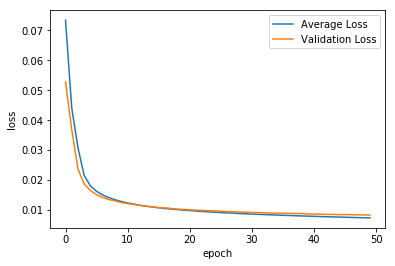

In [5]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Average Loss', 'Validation Loss'])

We have two curves of interest.  The Average Loss curve is the average loss over each epoch.  The Validation Loss curve is the average loss of the validation set at the end of each epoch.  Note that at the very begining, the average loss is higher than the validation.  This is because the network performes poorly, and the training improved the loss drastically over the course of the epoch.  The validation is only calculated using the network in its state at the end of the epoch.  However after the network learns on the training data, the training data starts to out perform the validation data.  This is because the training process is directly reducing the error for the training data, the fact that its performance on the validation continues to improve indicates that the network is learning relevant patterns and structures in the data.  If the validation performance begins to degrade while the training performance continues to improve, this is indicative of a common problem in machine learning where the network, instead of learning meaningful patterns in the data, is instead simply memorizing the training set, thus improving its performace on the training set, but loosing the ability to expand that knowledge to cases it has not seen in training.

We can also look at some of the classifications themselves.  Lets pick out the case of each number that the classifier is most sure about.

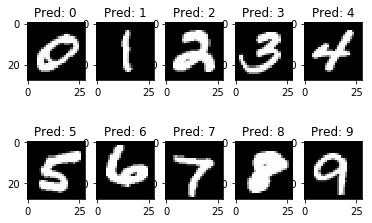

In [6]:
best = np.argmax(pred, axis=0)

plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(valid_dat[best[i], :, :], cmap='gray')
    plt.title('Pred: %d'%(i,))

Here we can see a case of each number that was correctly classified.

## On Your Own

Now that we have gone through a demo of using a neural network to classify integer drawings from the MNIST data set, here are a few exercises to do on your own.  It is recommended to make a copy of the `MNISTIntegerClassification.py` file which contains all the code used here and modify it.

1. Examine the final results:
    1. What is the overall successfull classification rate?
    2. What is the success rate for each integer?
    3. What integers does it have a hard time classifying?  Why?
    4. Look at some of the drawings it fails on, do they look clear to you?
2. Improve Performance:
    1. How does the performace improve when you make the current layers larger?
    2. What if you add a new dense layer?
    3. What if you put a convolutional layer in front?  (Note you will need to put the convolutional layer before the flatten layer)
    4. What if you let it train longer?